Please Run Code in Order

In [ ]:
#Importing Libraries
from numpy.core.numeric import True_
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files
import tqdm as tq
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
#Check for gpu or cpu
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print('gpu')
else:
  device = torch.device("cpu")

print(device)

gpu
cuda:0


In [ ]:
#Helper Functions
def ConvertDataFrameToNumpy(dataFrame):
    dataFrame = dataFrame.to_numpy()
    return dataFrame

def plot(x,y):
    plt.plot(x,y)
    plt.show()

def readFinanceCSV(dataFrame):
    date_name = dataFrame["Date"]
    openPrice_name = dataFrame["Open"]
    highPrice_name = dataFrame["High"]
    lowPrice_name = dataFrame["Low"]
    closePrice_name = dataFrame["Close"]
    date = ConvertDataFrameToNumpy(date_name)
    openPrice = ConvertDataFrameToNumpy(openPrice_name)
    highPrice = ConvertDataFrameToNumpy(highPrice_name)
    lowPrice = ConvertDataFrameToNumpy(lowPrice_name)
    closePrice = ConvertDataFrameToNumpy(closePrice_name)
    return date,openPrice,highPrice,lowPrice,closePrice

def ConvertToTorch(x):
    x = torch.from_numpy(x)
    x = x.float()
    x = x.unsqueeze(1)
    return x

def ConvertToTorch1(x):
    x = torch.from_numpy(x)
    x = x.float()
    return x

def trainModel(train_data,labels,epochs):
  loss_arr = []
  for i in tq.tqdm(range(epochs)):
      pred = model(train_data)
      loss = crit(pred,labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_arr.append(loss.item())

  plt.title('Loss over Iteration')
  plot(range(epochs),loss_arr)
  return pred

#Moving Window Method for Time Series Data
def MovingWindow(stock, lookback):
    data = []
  
    # create all possible sequences of length seq_len
    for index in range(len(stock) - lookback): 
        data.append(stock[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0];
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    return [x_train, y_train]

def transform_back(x,scaler):
  x = x.detach().numpy()
  x = scaler.inverse_transform(x)
  x = np.squeeze(x,axis = 1)
  return x

    

In [ ]:
print('Please Upload Training Data')
uploaded = files.upload()
filename = next(iter(uploaded))
print(filename)
print('Please Upload Test Data')
test_uploaded = files.upload()
filename_test = next(iter(test_uploaded))

Please Upload Training Data


Saving GOOGL_train.csv to GOOGL_train.csv
GOOGL_train.csv
Please Upload Test Data


Saving GOOGL_test.csv to GOOGL_test.csv


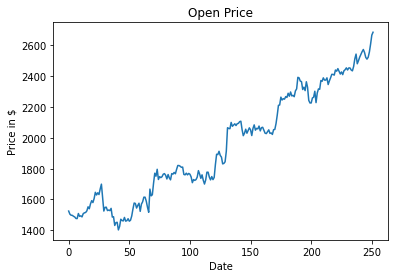

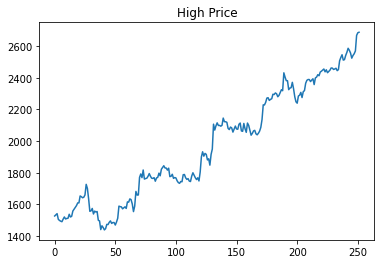

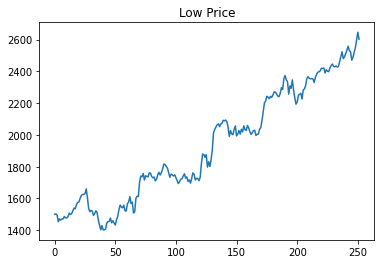

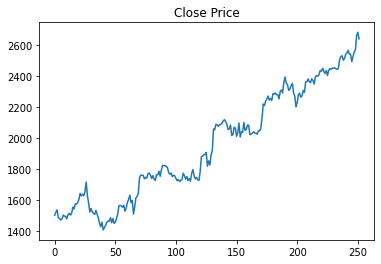

In [ ]:
#Data Loading 
df = pd.read_csv(filename)
data = readFinanceCSV(df)
date = data[0]
openPrice = data[1]
highPrice = data[2]
lowPrice = data[3]
closePrice = data[4]

plt.title('Open Price')
t = range(len(date))
plt.xlabel('Date')
plt.ylabel('Price in $')
plot(t,openPrice)
plt.title('High Price')
plot(t,highPrice)
plt.title('Low Price')
plot(t,lowPrice)
plt.title('Close Price')
plot(t,closePrice)

#Some edits on the data set
openPrice = ConvertToTorch(openPrice)
highPrice = ConvertToTorch(highPrice)
lowPrice = ConvertToTorch(lowPrice)
closePrice = ConvertToTorch(closePrice)

#Create training data on x
x_train = torch.unsqueeze(torch.linspace(0, len(date), len(date)), dim=1)

In [ ]:
#Read Test Data
df_test = pd.read_csv(filename_test)
data_test = readFinanceCSV(df_test)
date_test = data_test[0]
openPrice_test = data_test[1]
highPrice_test = data_test[2]
lowPrice_test = data_test[3]
closePrice_test = data_test[4]

openPrice_test = ConvertToTorch(openPrice_test)
highPrice_test = ConvertToTorch(highPrice_test)
lowPrice_test = ConvertToTorch(lowPrice_test)
closePrice_test = ConvertToTorch(closePrice_test)

**Simple Linear Regression Model For Prediciton Based on Open Prices**

In [ ]:
#Initialize Model
class LinearRegression(torch.nn.Module):
    def __init__(self,inputSize,outputSize):
        super(LinearRegression,self).__init__()
        self.linear = nn.Linear(inputSize,outputSize,bias = True)
    def forward(self,x):
        out = self.linear(x)
        return out
inputSize = 1
outputSize = 1
model = LinearRegression(inputSize,outputSize)

In [ ]:
#Defining Parameters
alpha = 0.2
epochs = 2000
#Defining critera and optimizer
crit = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = alpha)


100%|██████████| 2000/2000 [00:00<00:00, 2055.55it/s]


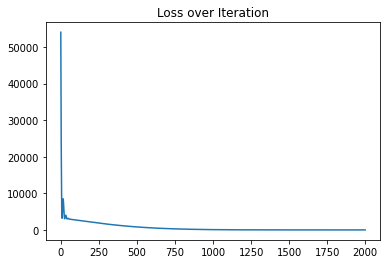

In [ ]:
prediction = trainModel(x_train,openPrice,epochs)

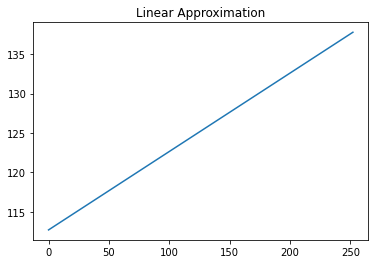

In [ ]:
#Prediction Graph
y_pred = model.forward(x_train)
plt.title('Linear Approximation')
plot(x_train,y_pred.detach().numpy())

Mean Squared Error: 63.77615


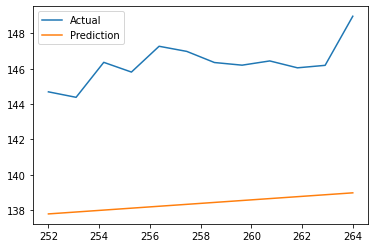

In [ ]:
#Comparison with Test Data
t = torch.unsqueeze(torch.linspace(252, 252+len(date_test), len(date_test)), dim=1)
plt.plot(t,openPrice_test)
x = torch.unsqueeze(torch.linspace(252, 252+len(date_test), len(date_test)), dim=1)
y_pred = model.forward(x)
plt.plot(x,y_pred.detach().numpy())
plt.legend(['Actual','Prediction'])

#Calculate Mean Squared Error
result = mean_squared_error(y_pred.detach().numpy(),openPrice_test)
print('Mean Squared Error:', result)

**Deeper Linear Network with 2 Hidden Layers with Only 1 Variable (Open Price)**

In [ ]:
#Initialize Model
class DeepModel(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_hidden2, n_output):
        super(DeepModel, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)   # hidden layer 1 with 200 neurons
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden2)   # hidden layer 2 with 100 neurons
        self.predict = torch.nn.Linear(n_hidden2, n_output)   # output layer
        self.relu = nn.ReLU() #activation

    def forward(self, x):
        x = self.hidden1(x)    # activation function for hidden layer
        x = self.relu(x)
        x = self.hidden2(x)  
        x = self.relu(x)
        x = self.predict(x)             # linear output
        return x
model = DeepModel(1,200,100,1)

In [ ]:
#Defining Parameters
alpha = 1e-2
epochs = 10000 #number of epochs learns training data better

#Defining critera and optimizer
crit = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = alpha)

100%|██████████| 10000/10000 [00:20<00:00, 496.83it/s]


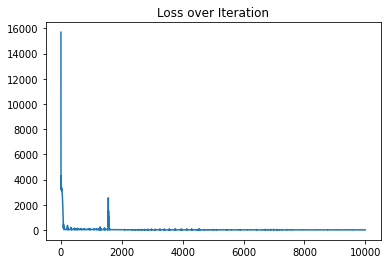

In [ ]:
prediction = trainModel(x_train,openPrice,epochs)

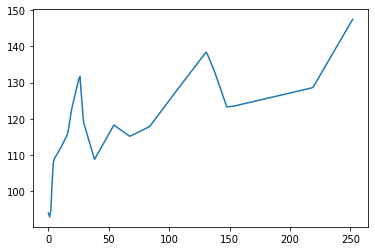

In [ ]:
#Prediction Graph
x = ConvertToTorch(np.linspace(0,252,252)) #Create Mock Test Data which corresspond to future days
x = x.unsqueeze(1)
y_pred = model.forward(x)
y_plot = y_pred.detach().numpy()
x_plot = x.detach().numpy()
plot(x_plot.squeeze(),y_plot.squeeze())

Mean Squared Error: 22.67592


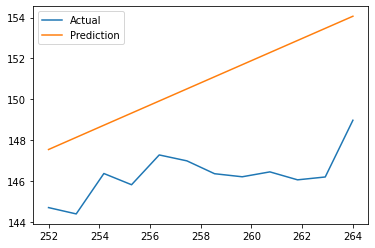

In [ ]:
#Comparison with Test Data
t = torch.unsqueeze(torch.linspace(252, 252+len(date_test), len(date_test)), dim=1)
plt.plot(t,openPrice_test)
x = torch.unsqueeze(torch.linspace(252, 252+len(date_test), len(date_test)), dim=1)
y_pred = model.forward(x)
plt.plot(x,y_pred.detach().numpy())
plt.legend(['Actual','Prediction'])

#Calculate Mean Squared Error
result = mean_squared_error(y_pred.detach().numpy(),openPrice_test)
print('Mean Squared Error:', result)

**Simple RNN with Averaged Targets (Closing,Opening,High,Low Price)**

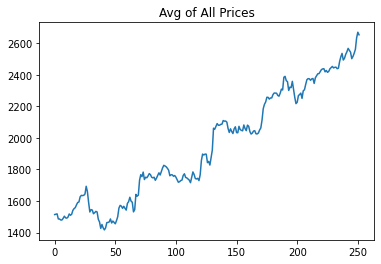

Train Shape:  (252, 1)
Test Shape:  (12, 1)


In [ ]:
#Take average of all variables
new = (openPrice+closePrice+highPrice+lowPrice)/4
plt.title('Avg of All Prices')
plot(range(len(new)),new)
#Convert to Numpy
new = new.numpy()

#Scale Values between -1 and 1
scaler_train = MinMaxScaler(feature_range=(-1,1)).fit(new)
scaler_test = MinMaxScaler(feature_range=(-1,1)).fit(new)
shifted = scaler_train.transform(new)
print('Train Shape: ', shifted.shape)

#Training Data
lookback = 5 # choose sequence length
x_train, y_train = MovingWindow(shifted, lookback)

x_train = ConvertToTorch1(x_train)
y_train = ConvertToTorch1(y_train)

#Creating Test Data
new_test = (openPrice_test+closePrice_test+highPrice_test+lowPrice_test)/4
new_test = new_test.numpy()
test_shifted = scaler_test.fit_transform(new_test.reshape(-1,1))
print('Test Shape: ',test_shifted.shape)
lookback = 3
x_test,y_test = MovingWindow(test_shifted, lookback)
x_test = ConvertToTorch1(x_test)
y_test = ConvertToTorch1(y_test)



In [ ]:
#Initialize Model
class ShallowRNN(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_layers):
        super(ShallowRNN, self).__init__()
        self.hidden = n_hidden
        self.num_layers = n_layers
        self.rnn = nn.RNN(n_feature,n_hidden,n_layers,batch_first=True)
        self.output = nn.Linear(n_hidden,n_output)
        self.relu = nn.ReLU()
    def forward(self, x):
       h0 = torch.zeros(self.num_layers,x.size(0),self.hidden) #initial hidden state
       x,hidden = self.rnn(x,h0.detach()) #output and hidden state
       x = self.relu(x)
       #decode hidden state of last timestep
       x = x[:,-1,:]
       x = self.output(x)
       return x

model = ShallowRNN(1,10,1,3)
print(model)

ShallowRNN(
  (rnn): RNN(1, 10, num_layers=3, batch_first=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
#Defining Parameters
alpha = 1e-2
epochs = 1000 #number of epochs learns training data better

#Defining critera and optimizer
crit = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = alpha)

100%|██████████| 1000/1000 [00:03<00:00, 311.10it/s]


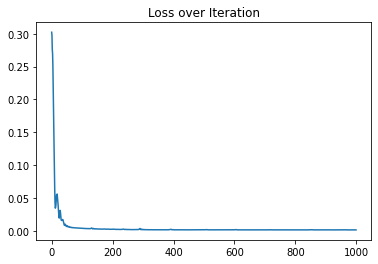

In [ ]:
prediction = trainModel(x_train,y_train,epochs)

100%|██████████| 1000/1000 [00:02<00:00, 483.29it/s]


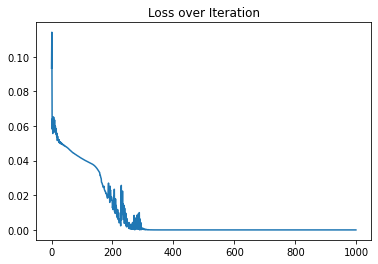

In [ ]:
prediction_test = trainModel(x_test,y_test,epochs)

(247,)


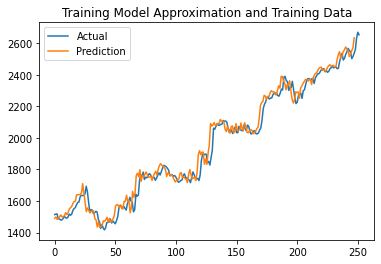

In [ ]:
#Prediction Graph
prediction = transform_back(prediction,scaler_train)
print(prediction.shape)

time = np.linspace(0,len(prediction),len(prediction))
plt.title('Training Model Approximation and Training Data')
plt.plot(range(len(new)),new)
plt.plot(time,prediction)
plt.legend(['Actual','Prediction'])

MSE:  166.8244


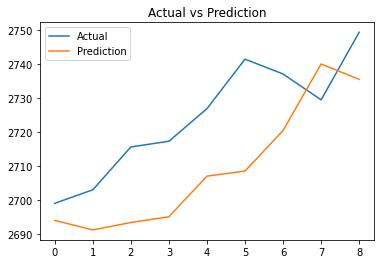

In [ ]:
y_test_pred = model(x_test)
y_test_pred = transform_back(y_test_pred,scaler_test)

new_time = len(y_test)

plt.title('Actual vs Prediction')
plt.plot(range(new_time),new_test[len(new_test)-new_time:len(new_test)])
plt.plot(range(new_time),y_test_pred)
plt.legend(['Actual','Prediction'])

#Calculate Mean Squared Error
y_test = transform_back(y_test,scaler_test)
result = mean_squared_error(y_test_pred,y_test)
print('MSE: ',result)


**LSTM Implementation of RNN with Average Price**

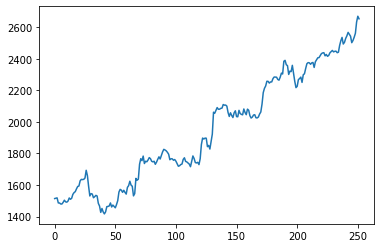

Train Shape:  (252, 1)
Test Shape:  (12, 1)


In [ ]:
#Data Initialization 
#Take average of all variables
new = (openPrice+closePrice+highPrice+lowPrice)/4
plot(range(len(new)),new)
#Convert to Numpy
new = new.numpy()

#Scale Values between -1 and 1
scaler_train = MinMaxScaler(feature_range=(-1,1)).fit(new)
scaler_test = MinMaxScaler(feature_range=(-1,1)).fit(new)
shifted = scaler_train.transform(new)
print('Train Shape: ', shifted.shape)

#Training Data
lookback = 10 # choose sequence length
x_train, y_train = MovingWindow(shifted, lookback)
x_train = ConvertToTorch1(x_train)
y_train = ConvertToTorch1(y_train)

#Creating Test Data
new_test = (openPrice_test+closePrice_test+highPrice_test+lowPrice_test)/4
new_test = new_test.numpy()
test_shifted = scaler_test.fit_transform(new_test.reshape(-1,1))
print('Test Shape: ',test_shifted.shape)
lookback = 3
x_test,y_test = MovingWindow(test_shifted, lookback)
x_test = ConvertToTorch1(x_test)
y_test = ConvertToTorch1(y_test)


In [ ]:
#Initialize Model
class LSTM(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_layers):
        super(LSTM, self).__init__()
        self.hidden = n_hidden
        self.num_layers = n_layers
        self.rnn = nn.LSTM(n_feature,n_hidden,n_layers,batch_first=True)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n_hidden,n_output)

    def forward(self, x):
       h0 = torch.zeros(self.num_layers,x.size(0),self.hidden) #initial hidden state
       c0 = torch.zeros(self.num_layers,x.size(0),self.hidden)
       x,(h,c) = self.rnn(x,(h0.detach(),c0.detach())) #output and hidden state
       x = self.relu(x)
       #decode hidden state of last timestep
       x = x[:,-1,:]
       x = self.output(x)
       return x

model = LSTM(1,10,1,3)
print(model)

LSTM(
  (rnn): LSTM(1, 10, num_layers=3, batch_first=True)
  (relu): ReLU()
  (output): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
#Defining Parameters
alpha = 1e-2
epochs = 1000 #number of epochs learns training data better

#Defining critera and optimizer
crit = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = alpha)
print(x_train.shape)

torch.Size([242, 9, 1])


100%|██████████| 1000/1000 [00:13<00:00, 73.52it/s]


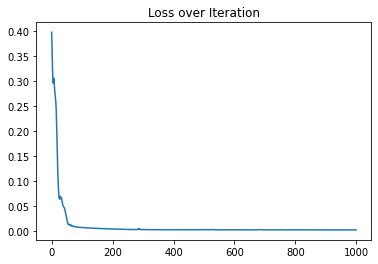

In [ ]:
prediction = trainModel(x_train,y_train,epochs)

100%|██████████| 1000/1000 [00:02<00:00, 362.69it/s]


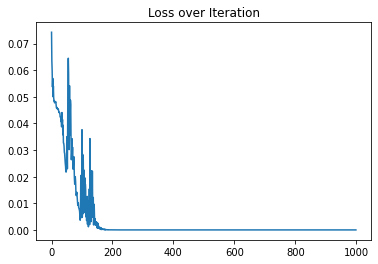

In [ ]:
#Testin plot
prediction_test = trainModel(x_test,y_test,epochs)

(242,)


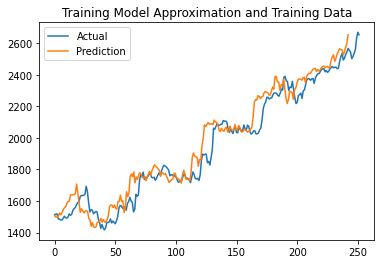

In [ ]:
#Prediction Graph
prediction = transform_back(prediction,scaler_train)
print(prediction.shape)

time = np.linspace(0,len(prediction),len(prediction))
plt.title('Training Model Approximation and Training Data')
plt.plot(range(len(new)),new)
plt.plot(time,prediction)
plt.legend(['Actual','Prediction'])

MSE:  92.52135


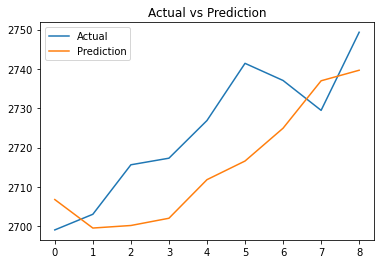

In [ ]:
#Testing Model
y_test_pred = model(x_test)
y_test_pred = transform_back(y_test_pred,scaler_test)
new_time = len(y_test)

plt.title('Actual vs Prediction')
plt.plot(range(new_time),new_test[len(new_test)-new_time:len(new_test)])
plt.plot(range(new_time),y_test_pred)
plt.legend(['Actual','Prediction'])

#Calculate Mean Squared Error
y_test = transform_back(y_test,scaler_test)
result = mean_squared_error(y_test_pred,y_test)
print('MSE: ',result)